## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
!wget $data

--2023-10-23 01:14:51--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  --.-KB/s    in 0.04s   

2023-10-23 01:14:51 (32.3 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [3]:
df = pd.read_csv("housing.csv")

In [4]:
df = (df
    .query(
        "ocean_proximity.isin(['<1H OCEAN', 'INLAND'])"
    )
    .fillna(0)
    .assign(
        median_house_value=lambda _df: np.log1p(_df["median_house_value"])
    )
)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
y_train = df_train["median_house_value"].values
y_val = df_val["median_house_value"].values
y_test = df_test["median_house_value"].values

del df_train['median_house_value'], df_val['median_house_value'], df_test['median_house_value']

In [7]:
dv = DictVectorizer(sparse=False)

def get_x_variable(dataframe):

    df_dict = dataframe.to_dict(orient='records')
    return dv.fit_transform(df_dict)

In [8]:
X_train = get_x_variable(df_train)
X_test = get_x_variable(df_test)
X_val = get_x_variable(df_val)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.

Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Which feature is used for splitting the data?

* **`ocean_proximity`**

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [14]:
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
round(rmse, 3)

0.245

What's the RMSE of this model on validation?

* **`0.245`**

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [15]:
rmse_scores = []

for n in np.arange(10, 200, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = round(mean_squared_error(y_val, y_pred, squared=False), 3)
    
    rmse_scores.append((n, rmse))

In [ ]:
df_scores = pd.DataFrame(rmse_scores, columns=['n_estimators', 'rmse'])

In [ ]:
df_scores

,n_estimators,rmse
0,10,0.245
1,20,0.238
2,30,0.236
3,40,0.235
4,50,0.234
5,60,0.234
6,70,0.234
7,80,0.234
8,90,0.234
9,100,0.234


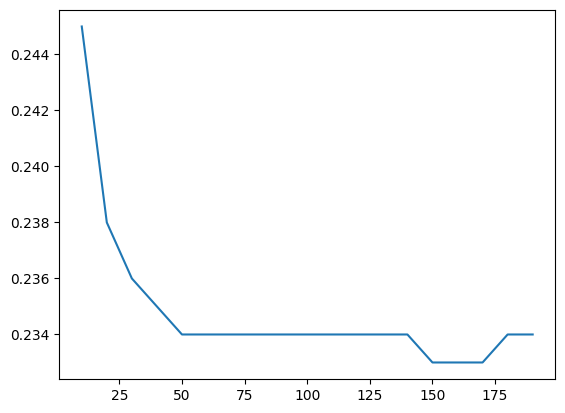

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

* **`160`**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [ ]:
rmse_scores = []
depth_list = [10, 15, 20, 25]
for d in depth_list:
    for n in np.arange(10, 200, 10):
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=d,
            random_state=1
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = round(mean_squared_error(y_val, y_pred, squared=False), 3)
        
        rmse_scores.append((d, n, rmse))

In [ ]:
cols = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(rmse_scores, columns=cols)

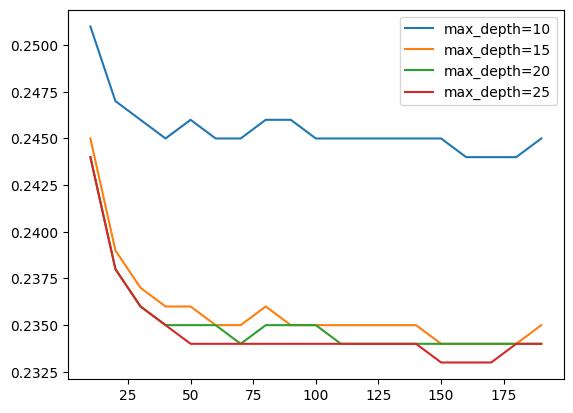

In [ ]:
for d in depth_list:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label=f'max_depth={d}')

plt.legend()

What's the best `max_depth`, using the mean RMSE?

* **`25`**

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [ ]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [ ]:
importances = rf.feature_importances_
features = dv.get_feature_names_out()
features_importances = pd.DataFrame(importances, index=features)
features_importances

,0
households,0.014465
housing_median_age,0.030018
latitude,0.102491
longitude,0.086038
median_income,0.335540
ocean_proximity=<1H OCEAN,0.218820
ocean_proximity=INLAND,0.147460
population,0.028272
total_bedrooms,0.015737
total_rooms,0.021158


What's the most important feature (among these 4)? 

* **`median_income`**

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [ ]:
!pip install xgboost
import xgboost as xgb

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/c1/cf/a662bc8f40588d54663edfe12980946670490bff0b6e793c7896a4fe36df/xgboost-2.0.0-py3-none-manylinux2014_x86_64.whl.metadata
  Using cached xgboost-2.0.0-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.0-py3-none-manylinux2014_x86_64.whl (297.1 MB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [ ]:
%%capture output
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    evals=watchlist
)

In [ ]:
s = output.stdout
print(s[:100])

[0]	train-rmse:0.44350	val-rmse:0.44250
[1]	train-rmse:0.36599	val-rmse:0.36916
[2]	train-rmse:0.315


In [ ]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    evals=watchlist
)

In [ ]:
s = output.stdout
print(s[:100])

[0]	train-rmse:0.52449	val-rmse:0.52045
[1]	train-rmse:0.48736	val-rmse:0.48443
[2]	train-rmse:0.454


Which eta leads to the best RMSE score on the validation dataset?

* **`0.3`**